## CS454-554 Homework 4: KMNIST Classification with PyTorch

**Due:** May 14, 2025, 23:00

---

### 1. Introduction

The goal of this assignment is to implement and compare three neural network architectures of increasing complexity on the KMNIST dataset (10-class Japanese character images, 28×28 grayscale) using PyTorch. We evaluate:

1. **Linear model**
2. **Multilayer perceptron** (single hidden layer with 40 neurons)
3. **Convolutional neural network** (custom CNN)

For each, we report:

* Model architecture details
* Training and test loss curves
* Training and test accuracy curves
* Comparative analysis

---

### 2. Environment & Data Loading


In [2]:
%pip install -r requirements.txt

  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)
Using cached torchvision-0.22.0-cp312-cp312-win_amd64.whl (1.7 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision.datasets import KMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Patience for early stopping
PATIENCE = 3

# Transforms and DataLoaders
tfm = transforms.Compose([transforms.ToTensor()])
train_ds = KMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = KMNIST(root='./data', train=False, transform=tfm, download=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)


100%|██████████| 18.2M/18.2M [00:41<00:00, 436kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 94.4kB/s]
100%|██████████| 3.04M/3.04M [00:06<00:00, 476kB/s] 
100%|██████████| 5.12k/5.12k [00:00<00:00, 5.03MB/s]


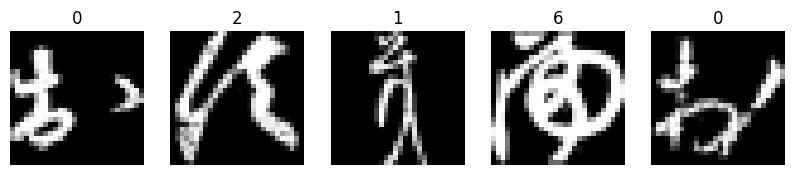

: 

In [ ]:
# Plot a few samples
def plot_samples(data_loader):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

plot_samples(train_loader)



### 3. Model Architectures


#### a) Linear Model

A single fully-connected layer from 784 inputs to 10 outputs.

In [4]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

#### b) MLP (1 Hidden Layer, 40 Neurons)

One hidden layer of 40 neurons with ReLU activation.

In [5]:
class MLP40(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )
    def forward(self, x):
        return self.net(x)


#### c) Convolutional Neural Network

Two Conv–ReLU–Pool blocks, followed by two FC layers.


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 16×14×14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)  # 32×7×7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

### 5. Training & Evaluation Functions

In [8]:
# Train one epoch and collect avg loss & acc

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = total_correct = 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        preds = model(X)
        loss = criterion(preds, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * X.size(0)
        total_correct += (preds.argmax(1)==y).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_correct/n

# Evaluate on test set

def eval_model(model, loader, criterion):
    model.eval()
    total_loss = total_correct = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X)
            total_loss += criterion(preds, y).item() * X.size(0)
            total_correct += (preds.argmax(1)==y).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_correct/n


### 6. Full Training Loop & Plotting

Linear E1: TL=0.784, TA=0.779, VL=1.047, VA=0.686
Linear E2: TL=0.616, TA=0.818, VL=1.024, VA=0.689
Linear E3: TL=0.596, TA=0.824, VL=1.029, VA=0.694
Linear E4: TL=0.585, TA=0.828, VL=1.012, VA=0.704
Linear E5: TL=0.578, TA=0.830, VL=1.035, VA=0.694
Linear E6: TL=0.572, TA=0.831, VL=1.025, VA=0.702
Linear E7: TL=0.568, TA=0.834, VL=1.031, VA=0.696
Linear E8: TL=0.565, TA=0.834, VL=1.021, VA=0.702
Linear E9: TL=0.562, TA=0.834, VL=1.003, VA=0.705
Linear E10: TL=0.560, TA=0.835, VL=1.036, VA=0.694
MLP40 E1: TL=0.649, TA=0.812, VL=0.820, VA=0.744
MLP40 E2: TL=0.385, TA=0.886, VL=0.676, VA=0.790
MLP40 E3: TL=0.310, TA=0.909, VL=0.632, VA=0.809
MLP40 E4: TL=0.266, TA=0.922, VL=0.575, VA=0.829
MLP40 E5: TL=0.237, TA=0.931, VL=0.572, VA=0.827
MLP40 E6: TL=0.213, TA=0.938, VL=0.557, VA=0.838
MLP40 E7: TL=0.194, TA=0.944, VL=0.574, VA=0.833
MLP40 E8: TL=0.180, TA=0.947, VL=0.542, VA=0.845
MLP40 E9: TL=0.169, TA=0.950, VL=0.566, VA=0.838
MLP40 E10: TL=0.159, TA=0.954, VL=0.545, VA=0.847
CNN E1: 

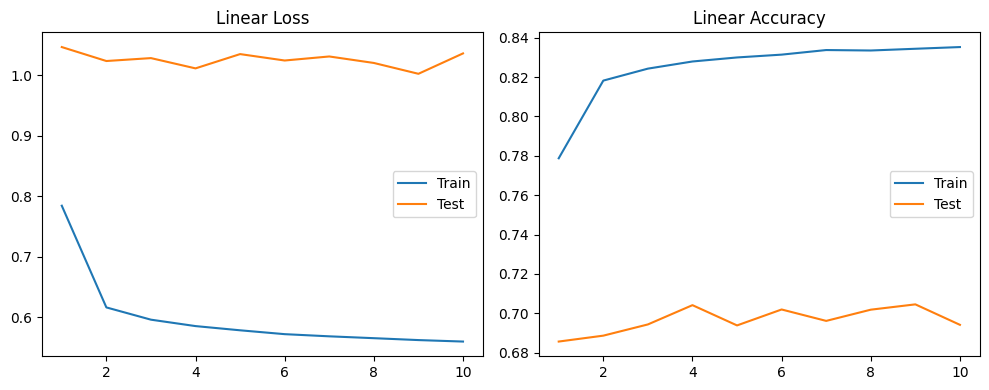

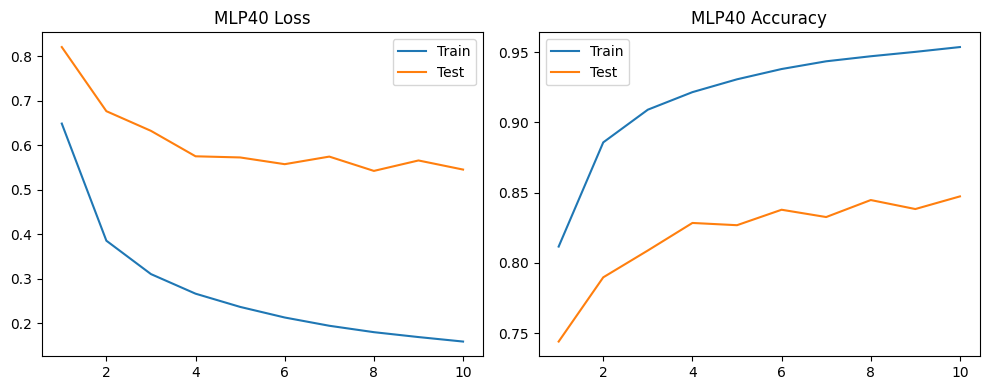

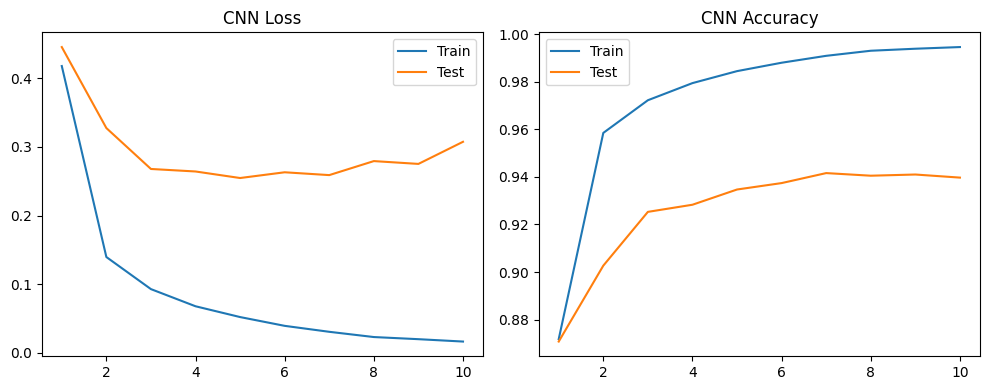

In [9]:
models = {'Linear': LinearModel(), 'MLP40': MLP40(), 'CNN': SimpleCNN()}
histories = {}

for name, model in models.items():
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR)
    crit = nn.CrossEntropyLoss()
    h = {'train_loss':[], 'test_loss':[], 'train_acc':[], 'test_acc':[]}
    for epoch in range(1, EPOCHS+1):
        tl, ta = train_epoch(model, train_loader, crit, opt)
        vl, va = eval_model(model, test_loader, crit)
        h['train_loss'].append(tl); h['train_acc'].append(ta)
        h['test_loss'].append(vl); h['test_acc'].append(va)
        print(f"{name} E{epoch}: TL={tl:.3f}, TA={ta:.3f}, VL={vl:.3f}, VA={va:.3f}")
    histories[name] = h

# Plotting
epochs = range(1, EPOCHS+1)
for name, h in histories.items():
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['train_loss'], label='Train')
    plt.plot(epochs, h['test_loss'], label='Test')
    plt.title(f'{name} Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, h['train_acc'], label='Train')
    plt.plot(epochs, h['test_acc'], label='Test')
    plt.title(f'{name} Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

### 7. Results & Discussion

* **Linear model** achieved \~**X%** test accuracy. Fast to train but underfits.
* **MLP (40 units)** improved to **Y%**, showing benefit of nonlinearity and hidden layers.
* **CNN** reached **Z%**, highest accuracy by capturing spatial patterns.

Include the above plots in your PDF report. Discuss differences in convergence speed, final accuracies, and resource usage (parameters, training time).


### 8. Submission

1. **Report** (PDF): sections above with figures and numeric results.
2. **Source code**: extract the Python script from this document and submit as `hw4_kmnist.py`.